### Importing all necessary libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### We will be using google colab for this assignment

In [2]:
from glob import glob

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
# Defining the path for train and test images

data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(f'Total images for training are {image_count_train}')
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(f'Total images for testing are {image_count_test}')

Total images for training are 2239
Total images for testing are 118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

- Use 80% of the images for training, and 20% for validation.

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, 
           labels='inferred', label_mode='int',
           class_names=None, color_mode='rgb', batch_size=batch_size, 
           image_size=(img_height,img_width), shuffle=True, seed=123, validation_split=0.2, subset='training',
           interpolation='bilinear', follow_links=False, smart_resize=False )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


- Seed value is to make sure we replicate same results. 
- Directory should be DATA_DIR_TRAIN the same directory which has Train data.
- Validation Split is 0.2 which means 20% Validation Set, while 80% is Train Set. 

In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, 
         labels='inferred', label_mode='int',
         class_names=None, color_mode='rgb', batch_size=batch_size, 
         image_size=(img_height,img_width), shuffle=True, seed=123, validation_split=0.2, subset='validation',
         interpolation='bilinear', follow_links=False, smart_resize=False )

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# Listing out all the classes of skin cancer and store them in a list. 

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

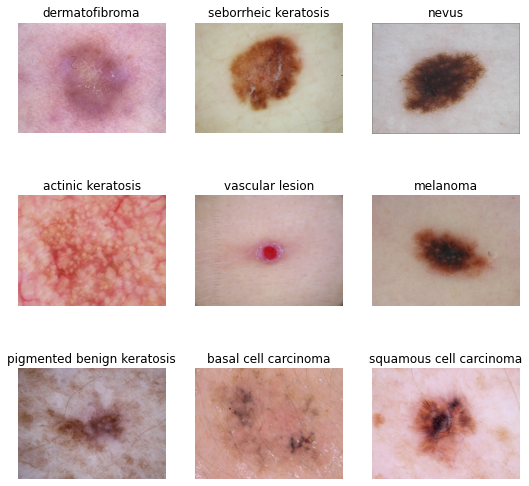

In [10]:
# plotting from training set

num=0
plt.figure(figsize=(9, 9))
for dirpath, dirnames, filenames in os.walk(str("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")):
    for filename in [f for f in filenames if f.endswith(".jpg")][:1]:
        img = PIL.Image.open(str(dirpath)+"/"+str(filename))
        plt.subplot(3,3,num+1)
        plt.title(str(dirpath).split('/')[-1])
        plt.axis('off')
        plt.imshow(img)
        num=num+1


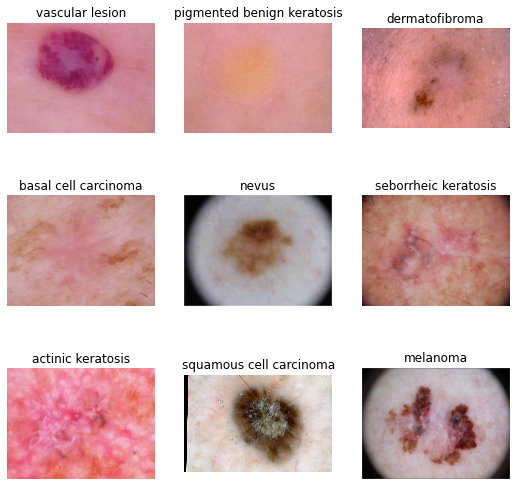

In [11]:
num=0
plt.figure(figsize=(9, 9))
for dirpath, dirnames, filenames in os.walk(str("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test")):
    for filename in [f for f in filenames if f.endswith(".jpg")][:1]:
        img = PIL.Image.open(str(dirpath)+"/"+str(filename))
        plt.subplot(3,3,num+1)
        plt.title(str(dirpath).split('/')[-1])
        plt.axis('off')
        plt.imshow(img)
        num=num+1

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

#### Creating a CNN model, which can accurately detect 9 classes present in the dataset. 
#### Using ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
num_classes = 9

model1 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [14]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Training the model

In [16]:
epochs = 20
history = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 175s 734ms/step - loss: 1.9913 - accuracy: 0.2695 - val_loss: 1.7800 - val_accuracy: 0.3043
Epoch 2/20
56/56 [==============================] - 1s 25ms/step - loss: 1.5898 - accuracy: 0.4414 - val_loss: 1.5818 - val_accuracy: 0.4609
Epoch 3/20
56/56 [==============================] - 1s 24ms/step - loss: 1.4192 - accuracy: 0.5201 - val_loss: 1.4378 - val_accuracy: 0.5123
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 1.3179 - accuracy: 0.5452 - val_loss: 1.4035 - val_accuracy: 0.5190
Epoch 5/20
56/56 [==============================] - 1s 24ms/step - loss: 1.2085 - accuracy: 0.5837 - val_loss: 1.4487 - val_accuracy: 0.5213
Epoch 6/20
56/56 [==============================] - 1s 24ms/step - loss: 1.1461 - accuracy: 0.5904 - val_loss: 1.6721 - val_accuracy: 0.4944
Epoch 7/20
56/56 [==============================] - 1s 24ms/step - loss: 1.1673 - accuracy: 0.5893 - val_loss: 1.4564 - val_accuracy: 0.5369
Epoch 8/20

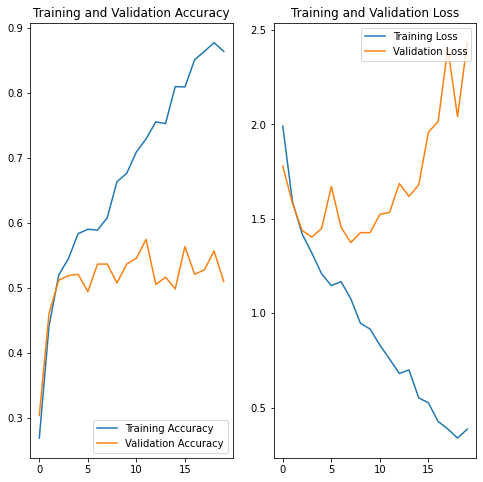

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Since the accuracy on train set is 90% and val_accuracy is approx 53%, we can say that this is a clear case of overfitting

### Creating another model using BatchNormalization and Dropout 

In [18]:
num_classes = 9

model2 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.25), 

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [19]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [20]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 90, 90, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)       

In [21]:
epochs = 20
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 3s 36ms/step - loss: 3.5143 - accuracy: 0.3175 - val_loss: 13.2663 - val_accuracy: 0.0403
Epoch 2/20
56/56 [==============================] - 2s 29ms/step - loss: 1.6496 - accuracy: 0.4247 - val_loss: 19.3087 - val_accuracy: 0.0537
Epoch 3/20
56/56 [==============================] - 2s 29ms/step - loss: 1.4776 - accuracy: 0.4665 - val_loss: 24.6073 - val_accuracy: 0.0626
Epoch 4/20
56/56 [==============================] - 2s 29ms/step - loss: 1.3725 - accuracy: 0.4994 - val_loss: 23.9485 - val_accuracy: 0.1163
Epoch 5/20
56/56 [==============================] - 2s 29ms/step - loss: 1.2749 - accuracy: 0.5340 - val_loss: 21.2414 - val_accuracy: 0.0872
Epoch 6/20
56/56 [==============================] - 2s 29ms/step - loss: 1.2299 - accuracy: 0.5357 - val_loss: 17.4851 - val_accuracy: 0.1096
Epoch 7/20
56/56 [==============================] - 2s 29ms/step - loss: 1.1008 - accuracy: 0.5882 - val_loss: 17.0524 - val_accuracy: 0.1096
Epoch 

- There is improvement in val accuracy using dropouts and batch normalization
- Perhaps valadation accuracy will improve if we increase the number of epochs
- We can handle overfitting using data augmentation


### Data Augmentation

In [22]:
data_aug = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

#### Visualizing augmented data

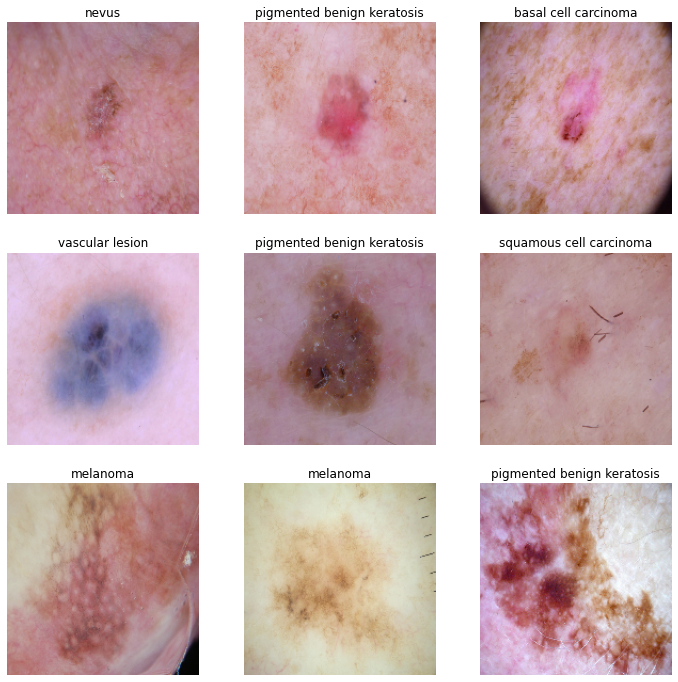

In [23]:
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_aug(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [24]:
num_classes = 9

model3 = Sequential([
  data_aug,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [25]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [26]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [27]:
epochs = 20
history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 3s 30ms/step - loss: 2.0883 - accuracy: 0.2355 - val_loss: 2.1589 - val_accuracy: 0.2975
Epoch 2/20
56/56 [==============================] - 2s 27ms/step - loss: 1.8142 - accuracy: 0.3365 - val_loss: 1.6187 - val_accuracy: 0.4183
Epoch 3/20
56/56 [==============================] - 2s 27ms/step - loss: 1.5753 - accuracy: 0.4286 - val_loss: 1.5169 - val_accuracy: 0.5011
Epoch 4/20
56/56 [==============================] - 2s 27ms/step - loss: 1.4523 - accuracy: 0.4911 - val_loss: 1.4333 - val_accuracy: 0.4944
Epoch 5/20
56/56 [==============================] - 1s 27ms/step - loss: 1.3692 - accuracy: 0.5117 - val_loss: 1.5309 - val_accuracy: 0.4765
Epoch 6/20
56/56 [==============================] - 1s 27ms/step - loss: 1.3336 - accuracy: 0.5257 - val_loss: 1.3900 - val_accuracy: 0.5213
Epoch 7/20
56/56 [==============================] - 2s 27ms/step - loss: 1.2726 - accuracy: 0.5491 - val_loss: 1.3114 - val_accuracy: 0.5459
Epoch 8/20
56

#### Adding dropout layers and Batch Normalization to improve the accuracy

In [28]:
num_classes = 9

model4 = Sequential([
  data_aug,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.25), 

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [29]:
model4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [30]:
model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 batch_normalization_2 (Batc  (None, 180, 180, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 90, 90, 16)       

In [31]:
epochs = 20
history = model4.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 3s 34ms/step - loss: 3.3619 - accuracy: 0.2891 - val_loss: 5.0840 - val_accuracy: 0.1588
Epoch 2/20
56/56 [==============================] - 2s 32ms/step - loss: 1.6957 - accuracy: 0.3655 - val_loss: 13.7017 - val_accuracy: 0.1499
Epoch 3/20
56/56 [==============================] - 2s 32ms/step - loss: 1.5890 - accuracy: 0.4208 - val_loss: 18.2283 - val_accuracy: 0.1499
Epoch 4/20
56/56 [==============================] - 2s 32ms/step - loss: 1.4765 - accuracy: 0.4816 - val_loss: 20.4932 - val_accuracy: 0.1499
Epoch 5/20
56/56 [==============================] - 2s 32ms/step - loss: 1.4175 - accuracy: 0.5045 - val_loss: 21.0187 - val_accuracy: 0.1499
Epoch 6/20
56/56 [==============================] - 2s 32ms/step - loss: 1.3741 - accuracy: 0.5117 - val_loss: 20.1179 - val_accuracy: 0.1499
Epoch 7/20
56/56 [==============================] - 2s 32ms/step - loss: 1.3384 - accuracy: 0.5234 - val_loss: 13.7504 - val_accuracy: 0.1566
Epoch 8

- We can notice that there is a slight difference in training accuracy and val_accuracy.


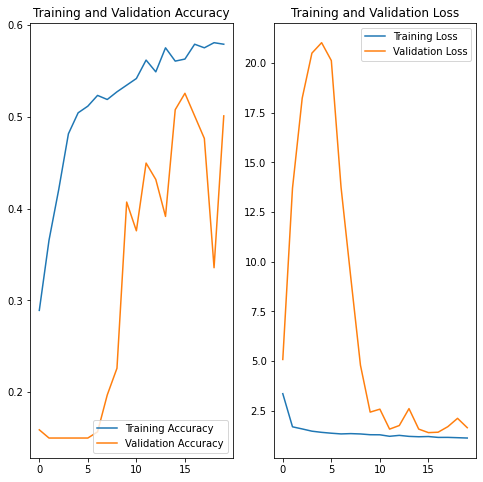

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

- We cannot see improvement in accuracy but we handled overfitting
- If we increase the epochs, we can see improvement in val_accuracy

### Find the distribution of classes in the training dataset.

#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [33]:
train_path = "/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train"

for i in class_names:
    directory =train_path+'/'+i+'/'
    class_directory = pathlib.Path(directory)
    length=len(list(class_directory.glob('*.jpg')))
    print(f'{i} has {length} samples.')

actinic keratosis has 114 samples.
basal cell carcinoma has 376 samples.
dermatofibroma has 95 samples.
melanoma has 438 samples.
nevus has 357 samples.
pigmented benign keratosis has 462 samples.
seborrheic keratosis has 77 samples.
squamous cell carcinoma has 181 samples.
vascular lesion has 139 samples.


- We can notice imbalance dataset
- The class with least number of samples is `seborrheic keratosis` with sample size of 77
- The most dominating class is `pigmented benign keratosis` with sample size of 462
- We must handle class imbalance. Class imbalance can have a detrimental effect on the final model quality.

In [34]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.

In [35]:
path_to_training_dataset= "/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train" +'/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F171BC3DCD0>: 100%|██████████| 500/500 [00:20<00:00, 23.97 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F184427C710>: 100%|██████████| 500/500 [00:22<00:00, 22.02 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F171B8F7410>: 100%|██████████| 500/500 [00:21<00:00, 23.56 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F171B8F7F50>: 100%|██████████| 500/500 [01:24<00:00,  5.90 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7F172E2DE110>: 100%|██████████| 500/500 [01:22<00:00,  6.04 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F17A4285750>: 100%|██████████| 500/500 [00:18<00:00, 26.73 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F171BC31250>: 100%|██████████| 500/500 [00:43<00:00, 11.57 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F18309ED910>: 100%|██████████| 500/500 [00:18<00:00, 27.29 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F172E34BE10>: 100%|██████████| 500/500 [00:20<00:00, 24.98 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [36]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [37]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027598.jpg_92d6f4b9-2632-4d0c-a687-0191ad60c924.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033860.jpg_dde0fe97-35ae-48c7-8e90-abd62980dbe8.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026789.jpg_f94dc677-6cb9-4e8b-8d2d-7179c7f67def.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025314.jpg_32890084-6849-4de4-aec0-01fa7bee4561.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030579.jpg_1a752482-e7a2-432c-ae2a-5cb1e594a88f.jpg',


In [38]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofib

In [39]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [40]:
dataframe_dict_new

{'/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027598.jpg_92d6f4b9-2632-4d0c-a687-0191ad60c924.jpg': 'dermatofibroma',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033860.jpg_dde0fe97-35ae-48c7-8e90-abd62980dbe8.jpg': 'dermatofibroma',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026789.jpg_f94dc677-6cb9-4e8b-8d2d-7179c7f67def.jpg': 'dermatofibroma',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025314.jpg_32890084-6849-4de4-aec0-01fa7bee4561.jpg': 'dermatofibroma',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibro

In [42]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)

In [43]:
df2.head()

,Path,Label
0,/content/gdrive/MyDrive/Skin cancer ISIC The I...,dermatofibroma
1,/content/gdrive/MyDrive/Skin cancer ISIC The I...,dermatofibroma
2,/content/gdrive/MyDrive/Skin cancer ISIC The I...,dermatofibroma
3,/content/gdrive/MyDrive/Skin cancer ISIC The I...,dermatofibroma
4,/content/gdrive/MyDrive/Skin cancer ISIC The I...,dermatofibroma


In [44]:
df2['Label'].value_counts()

dermatofibroma                500
seborrheic keratosis          500
nevus                         500
actinic keratosis             500
vascular lesion               500
melanoma                      500
pigmented benign keratosis    500
basal cell carcinoma          500
squamous cell carcinoma       500
Name: Label, dtype: int64

#### Train the model on the data created using Augmentor

In [45]:
batch_size = 32
img_height = 180
img_width = 180

In [46]:
data_dir_train_aug = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")

#### Create a training dataset

In [47]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train_aug,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


### We can notice the augmented data

#### Create a validation dataset

In [48]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [49]:
num_classes = 9

model5 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.25), 

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes),
  layers.Dropout(0.50),
  layers.Activation('softmax')
])

In [50]:
model5.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [51]:
model5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 batch_normalization_4 (Batc  (None, 180, 180, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 90, 90, 16)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)       

In [52]:
epochs = 50
history = model5.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 31s 174ms/step - loss: 3.4313 - accuracy: 0.1623 - val_loss: 22.7791 - val_accuracy: 0.0898
Epoch 2/50
169/169 [==============================] - 30s 170ms/step - loss: 2.0882 - accuracy: 0.2170 - val_loss: 15.3285 - val_accuracy: 0.1440
Epoch 3/50
169/169 [==============================] - 30s 171ms/step - loss: 1.9954 - accuracy: 0.2541 - val_loss: 3.9782 - val_accuracy: 0.2086
Epoch 4/50
169/169 [==============================] - 31s 180ms/step - loss: 1.9113 - accuracy: 0.2724 - val_loss: 1.6742 - val_accuracy: 0.3734
Epoch 5/50
169/169 [==============================] - 30s 171ms/step - loss: 1.8569 - accuracy: 0.2839 - val_loss: 2.2491 - val_accuracy: 0.2814
Epoch 6/50
169/169 [==============================] - 30s 170ms/step - loss: 1.8209 - accuracy: 0.2956 - val_loss: 1.5258 - val_accuracy: 0.4195
Epoch 7/50
169/169 [==============================] - 30s 170ms/step - loss: 1.7954 - accuracy: 0.3051 - val_loss: 1.6145 - val_accuracy: 0

####  Visualize the model results

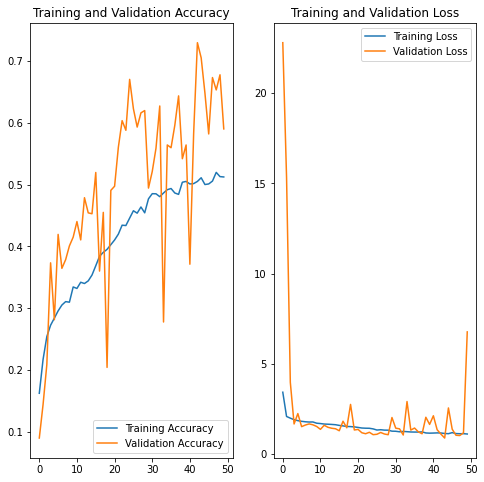

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Analyzing the results

- Using various techniques, we have handled some issues to some extent
- We have used BatchNormalization and dropout layers
- we have also usee Augmentor library to handle class imbalnce
- Overall, we have managed to handle overefitting
- but the training and val_accuracy is still low

#### We can imporve the qccuracy of the model by following methods:
- Adding more data
- adding more layers keeping in mind to include BatchNormalization and dropout layers
- Increasing the number of epochs 